In [1]:
from myai.imports import *
from visualbench.tasks.function_descent import FunctionDescent
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.inverse import MatrixInverse
import torchzero as tz

In [2]:
from myai.aicode.deepseek import GaussianHomotopy

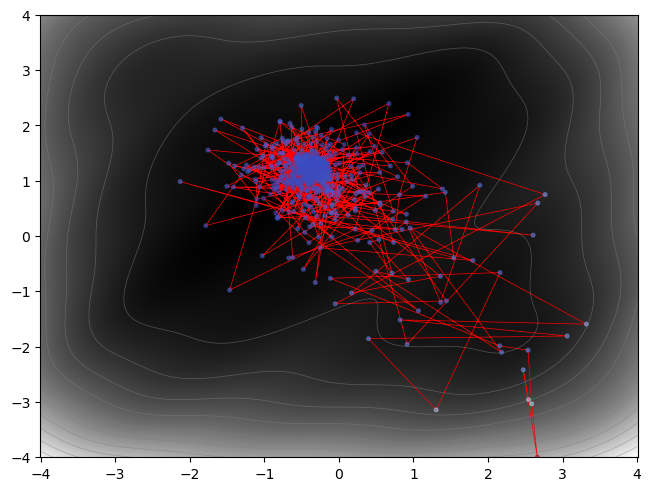

In [ ]:
bench = FunctionDescent('nonconvex')
opt = GaussianHomotopy(bench.parameters(), 1e-2, sigma_decay=0.98)
bench.run(opt, 1000,)
bench.plot_solution()

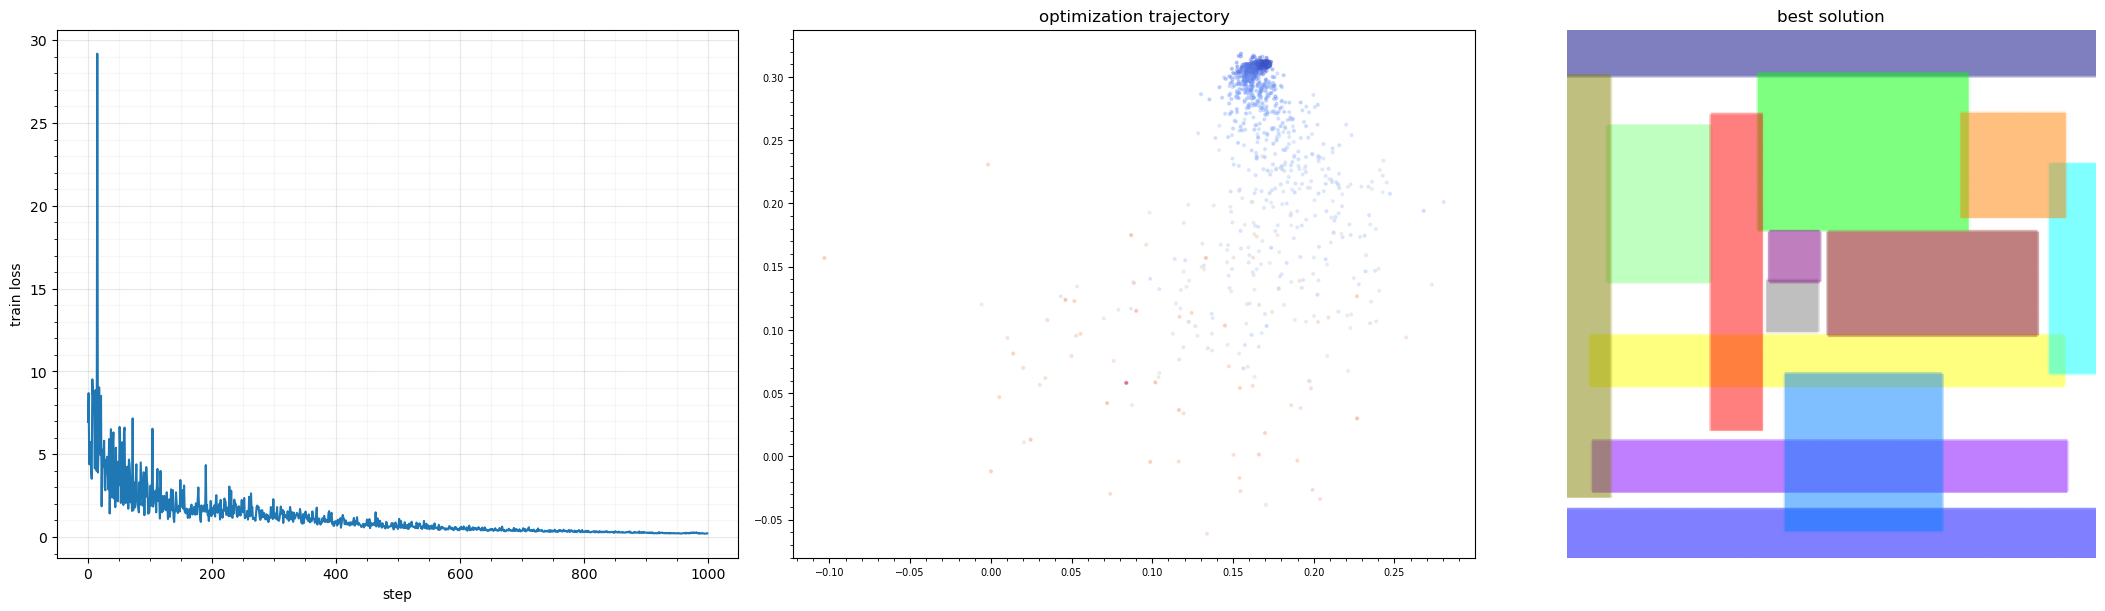

In [ ]:
bench = BoxPacking()
opt = GaussianHomotopy(bench.parameters(), 3e-2, sigma=0.5, sigma_decay=0.98)
bench.run(opt, 1000,)
bench.plot_summary(1, fig=Fig().figsize(24, 6))

In [173]:
bench.render_video('Gaussian homotopy')

1000/1000 | 17.94s               


image.shape = torch.Size([58, 58]), image.numel() = 3364


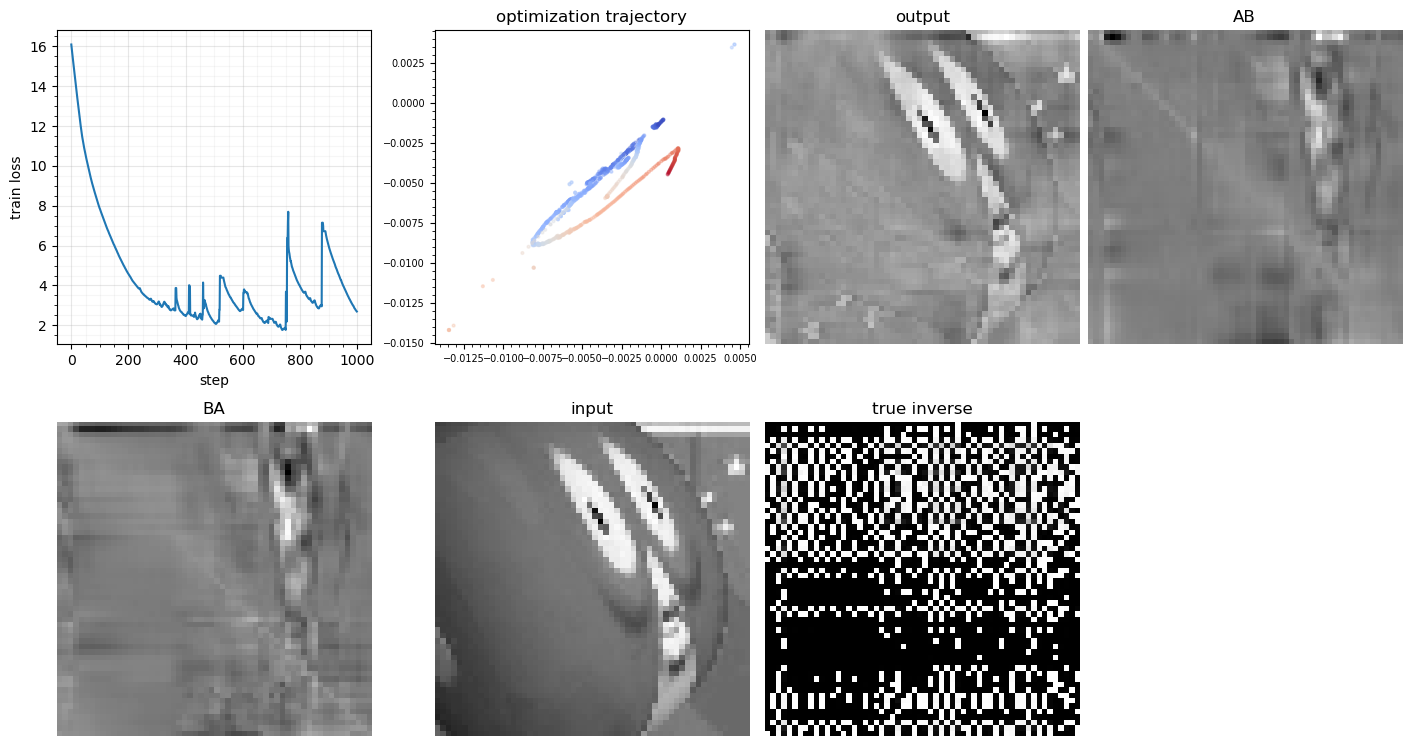

In [7]:
REDUCTION = 4
BW = True

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = GradientLossExtrapolationSGD(bench.parameters(), 1e-1, max_norm_diff=100)
bench.run(opt, 1000)
bench.plot_summary()

In [5]:
bench.render_video('glesgd inv', scale=4)

1000/1000 | 1.67s               


image.shape = torch.Size([58, 58]), image.numel() = 3364


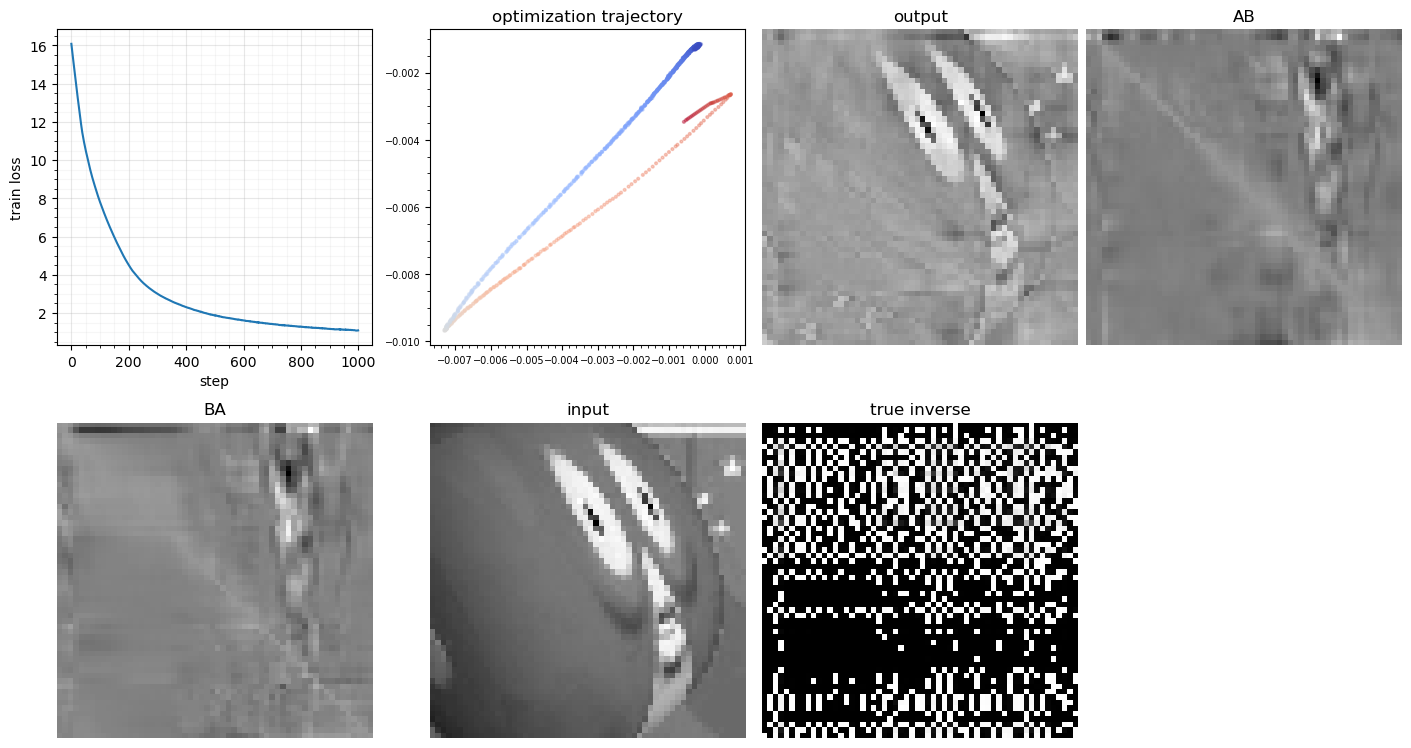

In [6]:
REDUCTION = 4
BW = True

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = torch.optim.SGD(bench.parameters(), 1e-1)
bench.run(opt, 1000)
bench.plot_summary()